In [2]:
import openturns as ot
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from shapley import ShapleyIndices, SobolIndices, KrigingModel, RandomForestModel
from shapley.tests import AdditiveGaussian
from shapley.tests.utils import true_gaussian_full_ind_sobol
from shapley.plots import set_style_paper, plot_sensitivity_results
from shapley.plots import plot_correlation_indices

%load_ext autoreload
%autoreload 2

%matplotlib inline

set_style_paper()

savefigs = True
ylim = [0., 1.]

In [3]:
dim = 3
beta = None
model = AdditiveGaussian(dim=dim, beta=beta)
model.margins = [ot.Normal()]*(dim-1) + [ot.Normal(0, 2.)]

In [13]:
n_corr = 20
corrs = np.linspace(-0.999, 0.999, n_corr)

n_var = 5000
n_outer = 100
n_inner = 50
n_perms = None
c_perms = np.math.factorial(dim) if n_perms is None else n_perms
max_budget = n_var + n_outer * n_inner * c_perms * (dim - 1)
n_sample = int(max_budget / (dim*4))
n_sample = 5400
print('Max budget:', max_budget)

estimator_sobol_full_ind = 'sobolmara'
n_boot = 300

('Max budget:', 65000)


In [5]:
use_meta_model = False
n_realization = 1
if use_meta_model:
    ot.RandomGenerator.SetSeed(0)
    np.random.seed(0)
    model_budget = 20
    n_realization = 300
    basis = 'quadratic'
    kernel = 'matern'
    library = 'sklearn'
    sampling = 'lhs'
    model_gp = KrigingModel(model=model, input_distribution=model.input_distribution)
    model_gp.generate_sample(n_sample=model_budget, sampling=sampling, sampling_type='uniform')
    model_gp.build(library=library, kernel=kernel, basis_type=basis)
    
    n_sample_cv = 10000
    score_q2_cv = meta_model.compute_score_q2_cv(n_sample_cv, sampling='monte-carlo')
    print('Cross Validation Q2 score with %d observations:' % (n_sample_cv), score_q2_cv)

In [15]:
result_indices = {'Shapley': [],
                  'First Sobol': [],
                  'Total Sobol': [],
                  'First full Sobol': [],
                  'Total full Sobol': [],
                  'First ind Sobol': [],
                  'Total ind Sobol': []
                 }

true_result_indices = {'Shapley': [],
                  'First Sobol': [],
                  'Total Sobol': [],
                  'First full Sobol': [],
                  'Total full Sobol': [],
                  'First ind Sobol': [],
                  'Total ind Sobol': []
                 }


for corr in corrs:
    print('Corr:', corr)
    theta = [0., 0., corr]
    model.copula_parameters = theta
    true_full_indices, true_ind_indices = true_gaussian_full_ind_sobol(theta, dim=dim)
        
    #Sobol Full and Ind
    if use_meta_model:
        sobol = SobolKrigingIndices(model.input_distribution)
        sobol.build_uncorr_sample(meta_model, n_sample, n_realization=n_realization)
    else:
        sobol = SobolIndices(model.input_distribution)
        sobol.build_uncorr_sample(model, n_sample)
        
    sobol_results_full = sobol.compute_indices(n_boot=n_boot, estimator=estimator_sobol_full_ind, indice_type='full')
    sobol_results_ind = sobol.compute_indices(n_boot=n_boot, estimator=estimator_sobol_full_ind, indice_type='ind')
    
    # Shapley
    if use_meta_model:
        shapley = ShapleyKrigingIndices(model.input_distribution)
        shapley.build_sample(model=model_gp, n_perms=None, n_var=n_var, n_outer=n_outer, n_inner=n_inner, n_realization=n_realization)
    else:
        shapley = ShapleyIndices(model.input_distribution)
        shapley.build_sample(model=model, n_perms=None, n_var=n_var, n_outer=n_outer, n_inner=n_inner)
    
    shapley_results = shapley.compute_indices(n_boot=n_boot)
    
    # Save results
    result_indices['Shapley'].append(shapley_results.full_shapley_indices.ravel())
    result_indices['First Sobol'].append(shapley_results.full_first_indices.ravel())
    result_indices['Total Sobol'].append(shapley_results.full_total_indices.ravel())
    result_indices['First full Sobol'].append(sobol_results_full.full_first_indices.ravel())
    result_indices['Total full Sobol'].append(sobol_results_full.full_total_indices.ravel())    
    result_indices['First ind Sobol'].append(sobol_results_ind.full_first_indices.ravel())
    result_indices['Total ind Sobol'].append(sobol_results_ind.full_total_indices.ravel())
    
    # Save true results
    true_result_indices['Shapley'].append(model.shapley_indices)
    true_result_indices['First Sobol'].append(model.first_sobol_indices)
    true_result_indices['Total Sobol'].append(model.total_sobol_indices)

('Corr:', -0.999)
('Corr:', -0.89384210526315788)
('Corr:', -0.78868421052631577)
('Corr:', -0.68352631578947376)
('Corr:', -0.57836842105263164)
('Corr:', -0.47321052631578953)
('Corr:', -0.36805263157894741)
('Corr:', -0.26289473684210529)
('Corr:', -0.15773684210526318)
('Corr:', -0.052578947368421058)
('Corr:', 0.052578947368420947)
('Corr:', 0.15773684210526306)
('Corr:', 0.26289473684210518)
('Corr:', 0.3680526315789473)
('Corr:', 0.47321052631578941)
('Corr:', 0.57836842105263153)
('Corr:', 0.68352631578947365)
('Corr:', 0.78868421052631577)
('Corr:', 0.89384210526315788)
('Corr:', 0.999)


In [16]:
true_result_indices['First ind Sobol'] = true_result_indices['Total Sobol']
true_result_indices['First full Sobol'] = true_result_indices['First Sobol']
true_result_indices['Total ind Sobol'] = true_result_indices['Total Sobol']
true_result_indices['Total full Sobol'] = true_result_indices['First Sobol']

In [27]:
n_tree = 100
rf_indices = np.zeros((n_corr, dim, n_tree))
for i, corr in enumerate(corrs):
    theta = [0., 0., corr]
    model.copula_parameters = theta
    model_rf = RandomForestModel(model, input_distribution=model.input_distribution)
    model_rf.generate_sample(n_sample=max_budget, sampling='monte-carlo', sampling_type='classic')
    model_rf.build(n_tree)
    forest = model_rf.reg_rf
    rf_indices[i] = np.asarray([tree.feature_importances_ for tree in forest.estimators_]).T

KeyboardInterrupt: 

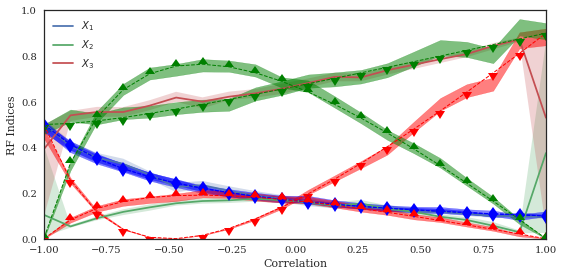

In [26]:
fig, ax = plt.subplots(figsize=(8, 4))
for i in range(dim):
    rf_indice = rf_indices[:, i]
    ax.plot(corrs, rf_indice.mean(axis=1), label="$X_%d$" % (i+1))
    quantiles = np.percentile(rf_indice, [1, 99], axis=1)
    ax.fill_between(corrs, quantiles[0, :], quantiles[1, :], alpha=0.25)
    
plot_correlation_indices(result_indices, corrs, n_boot, true_indices=true_result_indices, ax=ax, to_plot=to_plot, alpha=[0.025, 0.975], ci='error')
ax.legend(loc=0)
ax.set_ylim(ylim)
ax.set_xlim(corrs[0], corrs[-1])
ax.set_xlabel('Correlation')
ax.set_ylabel('RF Indices')
fig.tight_layout()

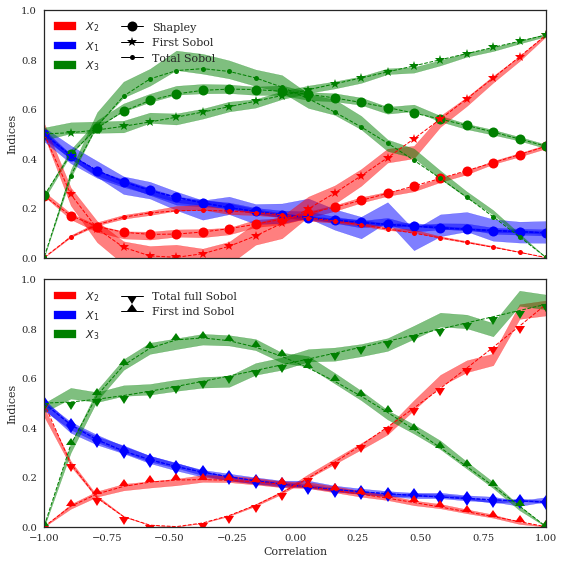

In [17]:
fig, axes = plt.subplots(2, 1, figsize=(8, 8), sharex=True, sharey=True)

ax = axes[0]
to_plot = ['Shapley', 'First Sobol', 'Total Sobol']
plot_correlation_indices(result_indices, corrs, n_boot, true_indices=true_result_indices, ax=ax, to_plot=to_plot, alpha=[0.025, 0.975], ci='error')
ax.set_xlabel('')

ax = axes[1]
to_plot = ['First ind Sobol', 'Total full Sobol']
plot_correlation_indices(result_indices, corrs, n_boot, true_indices=true_result_indices, ax=ax, to_plot=to_plot, alpha=[0.05, 0.95], ci='quantile')

fig.tight_layout()
fig.savefig('./output/correlation_gaussian_both_dim_%d_Nv_%d_No_%d_Ni_%d.pdf' % (dim, Nv, No, Ni))

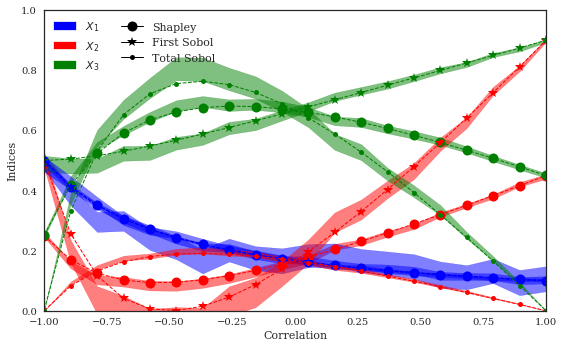

In [18]:
fig, ax=plt.subplots(figsize=(8, 5))

to_plot = ['Shapley', 'First Sobol', 'Total Sobol']

plot_correlation_indices(result_indices, corrs, n_boot, true_indices=true_result_indices, ax=ax, to_plot=to_plot, alpha=[0.025, 0.975], ci='error')
fig.tight_layout()
fig.savefig('./output/correlation_gaussian_dim_%d_Nv_%d_No_%d_Ni_%d.pdf' % (dim, Nv, No, Ni))

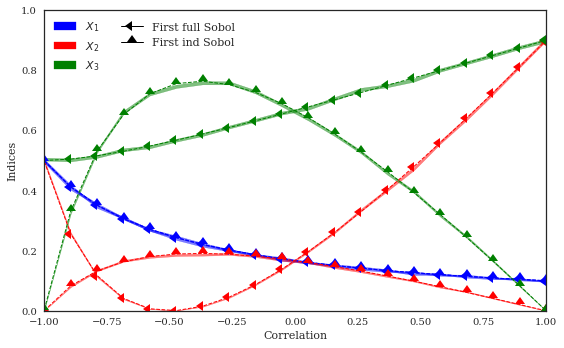

In [248]:
fig, ax=plt.subplots(figsize=(8, 5))

to_plot = ['First ind Sobol', 'First full Sobol']

plot_correlation_indices(result_indices, corrs, n_boot, true_indices=true_result_indices, ax=ax, to_plot=to_plot, alpha=[0.05, 0.95], ci='quantile')
fig.tight_layout()
fig.savefig('./output/correlation_gaussian_full_ind_dim_%d_Nv_%d_No_%d_Ni_%d.pdf' % (dim, Nv, No, Ni))

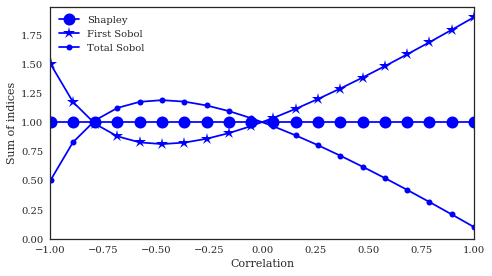

In [215]:
fig, ax = plt.subplots(figsize=(7, 4))

markers = {'Shapley': 'o',
           'First Sobol': '*',
           'Total Sobol': '.',
           'First full Sobol': 8,
           'Total full Sobol': 11,
           'First ind Sobol': 10,
           'Total ind Sobol': 11,
           }
    
to_plot = ['Shapley', 'First Sobol', 'Total Sobol']
for name in to_plot:
    indice_sum = np.c_[true_result_indices[name]].sum(axis=1)
    ax.plot(corrs, indice_sum, color='b', marker=markers[name], label='%s' % (name), markersize=12)
    
ax.set_xlabel('Correlation')
ax.set_ylabel('Sum of indices')
ax.set_xlim([-1., 1])
ax.set_ylim(0., None)
ax.legend(loc=0)
fig.tight_layout()
fig.savefig('./output/correlation_gaussian_sum.pdf')

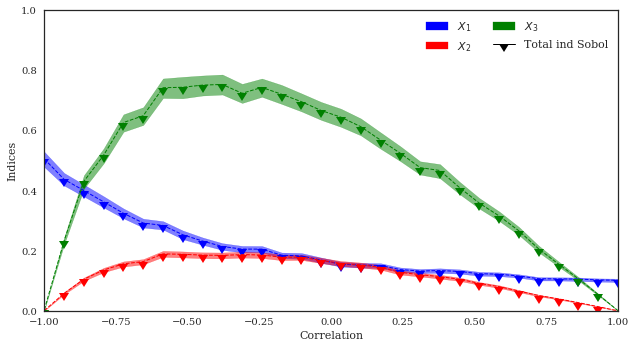

In [93]:
fig, ax = plt.subplots(figsize=(9, 5))

to_plot = ['Total ind Sobol']
plot_correlation_indices(result_indices, corrs, n_boot, ax=ax, to_plot=to_plot, alpha=[0.025, 0.975], ci='error')
fig.tight_layout()

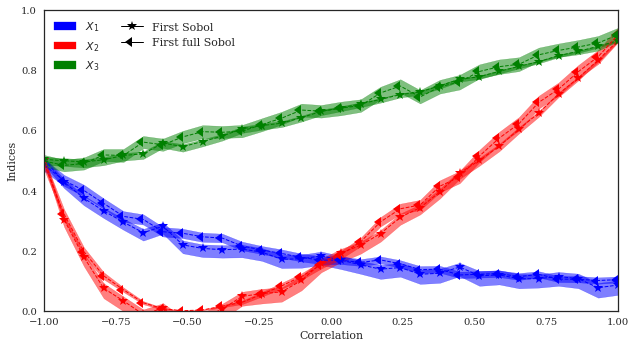

In [94]:
fig, ax = plt.subplots(figsize=(9, 5))
to_plot = ['First Sobol', 'First full Sobol']
plot_correlation_indices(result_indices, corrs, n_boot, ax=ax, to_plot=to_plot)
fig.tight_layout()

In [86]:
result_indices = {'Shapley': [],
                  'First Sobol': [],
                  'Total Sobol': [],
                  'First full Sobol': [],
                  'Total full Sobol': [],
                  'First ind Sobol': [],
                  'Total ind Sobol': []
                 }

shapley_kriging = SobolKrigingIndices(model.input_distribution)
shapley_kriging.
for corr in corrs:
    theta = [0., 0., corr]
    model.copula_parameters = theta
    true_full_indices, true_ind_indices = true_gaussian_full_ind_sobol(theta, dim=dim)
        
    #Sobol Full and Ind
    n_sample = int(max_budget / (dim*4))
    sobol = SobolIndices(model.input_distribution)
    sobol.build_uncorrelated_mc_sample(model, n_sample)
    sobol_results_full = sobol.compute_full_indices(n_boot=n_boot, estimator=estimator_sobol_full_ind)
    sobol_results_ind = sobol.compute_ind_indices(n_boot=n_boot, estimator=estimator_sobol_full_ind)
    
    # Shapley
    shapley = ShapleyIndices(model.input_distribution)
    shapley.build_mc_sample(model=model, n_perms=None, Nv=Nv, No=No, Ni=Ni)
    shapley_results = shapley.compute_indices(n_boot=n_boot)
    
    # Save results
    result_indices['Shapley'].append(shapley_results.full_shapley_indices.ravel())
    result_indices['First Sobol'].append(shapley_results.full_first_indices.ravel())
    result_indices['Total Sobol'].append(shapley_results.full_total_indices.ravel())
    result_indices['First full Sobol'].append(sobol_results_full.full_first_indices.ravel())
    result_indices['Total full Sobol'].append(sobol_results_full.full_total_indices.ravel())    
    result_indices['First ind Sobol'].append(sobol_results_ind.full_first_indices.ravel())
    result_indices['Total ind Sobol'].append(sobol_results_ind.full_total_indices.ravel())

SyntaxError: invalid syntax (<ipython-input-86-095bbefd695a>, line 11)